C:\Users\Aidan\miniconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[Text(0.5, 0, 'Number in dataset'), Text(0, 0.5, 'Classes')]

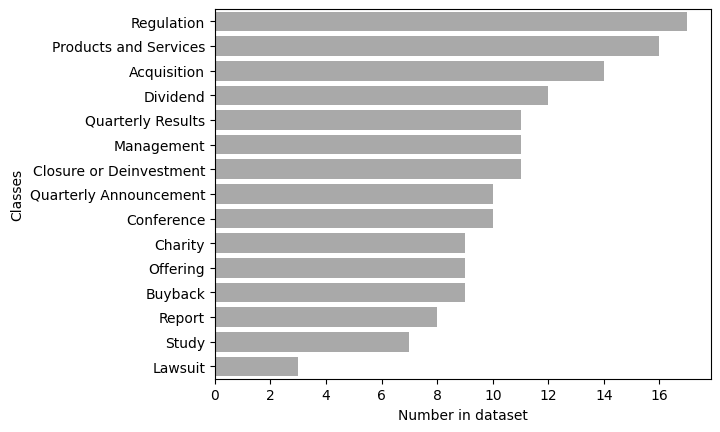

In [1]:
import os, json
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from transformers import AutoTokenizer, BertForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset, DatasetDict, load_dataset
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from transformers import (
    BertForSequenceClassification,
    AutoModelForSequenceClassification,
    BertTokenizerFast,
    TrainingArguments,
    Trainer,
    EvalPrediction,
)
from datasets import load_metric
import torch
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score


# list to stores dictionary of each ticher
data = []

# list for only the statements removes the headers 
pure_data = []

# stores all press statements that have been manually classed
press_statements_classed = []

# file location of json files, press statements
path_to_json = './data/'

# open all the json files and extend them to a list
for file_name in [file for file in os.listdir(path_to_json) if file.endswith('.json')]:
    with open(path_to_json + file_name, encoding="utf8") as json_file:
        file = json.load(json_file)
        data.extend(file)
        
# extend list of only press statements
for i in data:
    pure_data.extend(i['data'])

# create list with only statements that have been classed manually
for i in pure_data:
    if i.get("manual_class") is not None:
        press_statements_classed.append(i)

title_content_statements_X = [f'{press["press_title"]}, {press["content"]}' for press in press_statements_classed] 
statements_classes_Y = [press['manual_class'] for press in press_statements_classed]    

# get the total number of classes
num_classes = len(pd.Series(statements_classes_Y).value_counts())

sns.barplot(x=pd.Series(statements_classes_Y).value_counts().values, 
            y=pd.Series(statements_classes_Y).value_counts().index,
            color='darkgrey').set(xlabel='Number in dataset', ylabel='Classes')


In [2]:
# convert labels to raw numbers

le = preprocessing.LabelEncoder()

y_encode = le.fit(statements_classes_Y)

y_encode = le.transform(statements_classes_Y)

In [3]:
# data setup

press_with_labels = {'data': title_content_statements_X, 'label': y_encode}
press_with_labels_NB = {'data': title_content_statements_X, 'label': y_encode}
press_with_labels_BERT = {'data': title_content_statements_X, 'label': y_encode}

# Naive bayes pre proccesing and token

nlp = spacy.load('en_core_web_sm')

def spacy_tokeniser(doc):
    return [t.text for t in nlp(doc) if \
            not t.is_punct and \
            not t.is_space and \
            t.is_alpha]


def NB_preprocessing(release):
    """
    function removes stop words
    """
    
    release = release.lower() # press statement convert to lower case
    stop_words = set(stopwords.words('english')) # obtain stop words

    # Tokenize the sentence
    tokens = word_tokenize(release)

    # Remove stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]
    filtered_sentence = ' '.join(filtered_tokens) 
    return filtered_sentence

press_with_labels_NB['data'] = [NB_preprocessing(x) for x in press_with_labels_NB['data']]

# Fit and tranform the data using a count vectorizer
vectorizer = CountVectorizer()
vectorizer.fit_transform(press_with_labels_NB['data'])

press_with_labels_NB['data'] = vectorizer.transform(press_with_labels_NB['data']).todense()

# convert to dataset data type then split into test and train done to stay consist with other bert dataset
dataset_tokenised_NB = Dataset.from_dict(press_with_labels_NB)
dataset_tokenised_NB = dataset_tokenised_NB.train_test_split(test_size=0.3, seed=1)

In [4]:
# Bert tokenisation
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

press_with_labels_BERT = tokenizer(press_with_labels['data'], padding='max_length', max_length=215)
press_with_labels_BERT['label'] = press_with_labels['label']

dataset_tokenised_bert_pre_split = Dataset.from_dict(press_with_labels_BERT)
dataset_tokenised_bert = dataset_tokenised_bert_pre_split.train_test_split(test_size=0.3, seed=1)

In [5]:
# bert model training

LEARNING_RATE = 7e-5 
BATCH_SIZE = 4
EPOCHS = 15

model = BertForSequenceClassification.from_pretrained(checkpoint)

id2label = {k:k for k in range(num_classes)}
label2id = {k:k for k in range(num_classes)}

# class weight to try and solve class imablance
class_wts = compute_class_weight('balanced', classes= np.unique(dataset_tokenised_bert_pre_split['label']), y=dataset_tokenised_bert_pre_split['label'])


model = AutoModelForSequenceClassification.from_pretrained(checkpoint, id2label=id2label, label2id=label2id)


training_args = TrainingArguments(
    output_dir="./",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    evaluation_strategy="epoch",
    save_strategy="no",
    metric_for_best_model="accuracy",
    save_steps=False,
    weight_decay=0.01,
)

metric = load_metric("accuracy")

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss  
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_wts)).float().cuda()
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
    
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
#     recall = recall_score(y_true=labels, y_pred=pred)
#     precision = precision_score(y_true=labels, y_pred=pred)
#     f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy}

    
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenised_bert['train'],
    eval_dataset=dataset_tokenised_bert['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

done_model = trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,2.886807,0.083333
2,No log,2.808771,0.062500
3,No log,2.398203,0.395833
4,No log,2.008350,0.479167
5,No log,1.350972,0.687500
6,No log,1.218127,0.645833
7,No log,0.868060,0.770833
8,No log,0.910978,0.791667
9,No log,0.746991,0.833333
10,No log,0.673056,0.854167


In [6]:
# Naive bayes
nb = MultinomialNB()
nb.fit(dataset_tokenised_NB['train']['data'], dataset_tokenised_NB['train']['label'])

# results on test and train set
y_pred_train_NB = nb.predict(dataset_tokenised_NB['train']['data'])
y_pred_test_NB = nb.predict(dataset_tokenised_NB['test']['data'])

train_acc_NB = metrics.accuracy_score(dataset_tokenised_NB['train']['label'], y_pred_train_NB)
test_acc_NB = metrics.accuracy_score(dataset_tokenised_NB['test']['label'], y_pred_test_NB)

print(f'train accuracy = {train_acc_NB}')
print(f'test accuracy = {test_acc_NB}')
nb.alpha

train accuracy = 0.9908256880733946
test accuracy = 0.6458333333333334


1.0

Text(0.5, 1.0, 'Naive Bayes Confusion Matrix')

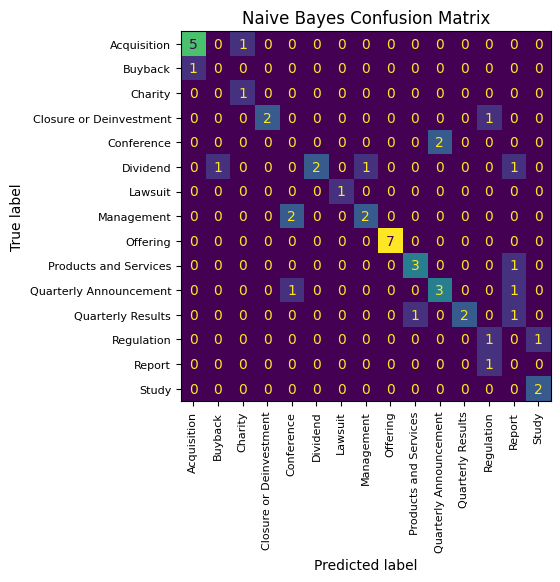

In [7]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_pred_test_NB, dataset_tokenised_NB['test']['label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

axes = plt.figure().add_subplot(111)

mapping = dict(zip(le.classes_, range(len(le.classes_))))
mapping = {y: x for x, y in mapping.items()}

ticklabels_x = []
ticklabels_y = []



disp = disp.plot(ax=axes)
disp.im_.colorbar.remove()
for ticklabel in axes.get_xticklabels():
    ticklabels_x.append(mapping[int(float(ticklabel.get_text()))])

    
for ticklabel in axes.get_yticklabels():
    ticklabels_y.append(mapping[int(ticklabel.get_text())])

axes.set_xticklabels(ticklabels_x)
axes.set_yticklabels(ticklabels_y)

plt.xticks(rotation='vertical', fontsize= 8)
plt.yticks( fontsize= 8)
plt.title("Naive Bayes Confusion Matrix")

In [8]:
# Random forest Classifier
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 1000)
  
# Train the model using the training sets
clf.fit(dataset_tokenised_NB['train']['data'], dataset_tokenised_NB['train']['label'])

y_pred_train_DT = clf.predict(dataset_tokenised_NB['train']['data'])
y_pred_test_DT = clf.predict(dataset_tokenised_NB['test']['data'])

train_acc_DT = metrics.accuracy_score(dataset_tokenised_NB['train']['label'], y_pred_train_DT)
test_acc_DT = metrics.accuracy_score(dataset_tokenised_NB['test']['label'], y_pred_test_DT)

print(f'train accuracy = {train_acc_DT}')
print(f'test accuracy = {test_acc_DT}')

train accuracy = 1.0
test accuracy = 0.4791666666666667


Text(0.5, 1.0, 'Random Forest Confusion Matrix')

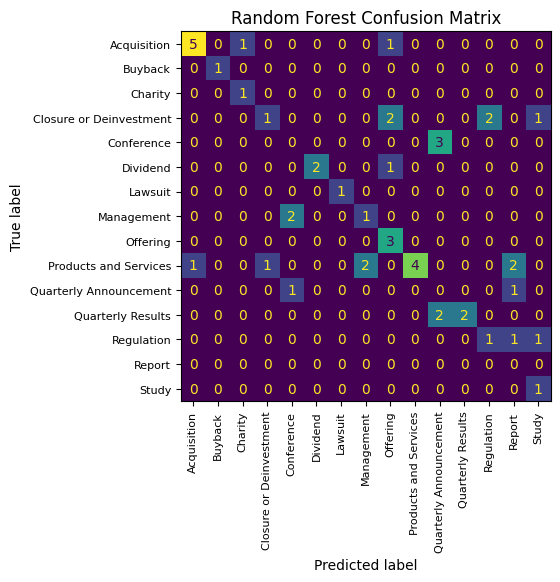

In [9]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_pred_test_DT, dataset_tokenised_NB['test']['label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

axes = plt.figure().add_subplot(111)

mapping = dict(zip(le.classes_, range(len(le.classes_))))
mapping = {y: x for x, y in mapping.items()}

ticklabels_x = []
ticklabels_y = []



disp = disp.plot(ax=axes)
disp.im_.colorbar.remove()
for ticklabel in axes.get_xticklabels():
    ticklabels_x.append(mapping[int(float(ticklabel.get_text()))])

    
for ticklabel in axes.get_yticklabels():
    ticklabels_y.append(mapping[int(ticklabel.get_text())])

axes.set_xticklabels(ticklabels_x)
axes.set_yticklabels(ticklabels_y)

plt.xticks(rotation='vertical', fontsize= 8)
plt.yticks( fontsize= 8)
plt.title("Random Forest Confusion Matrix")

In [17]:
model = model.to('cuda')

# generate prediction from bert
raw_pred, f, c = trainer.predict(dataset_tokenised_bert['test'])

# returns probailites for all class so convert to just one the largest
y_pred = np.argmax(raw_pred, axis=1)


Text(0.5, 1.0, 'BERT Confusion Matrix')

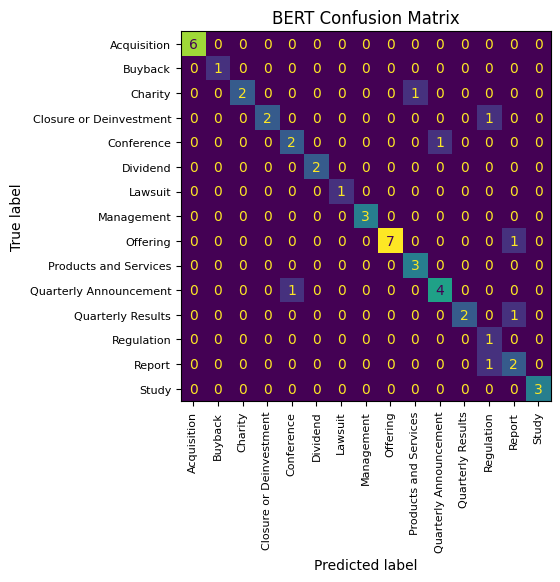

In [21]:
# bert confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_pred, dataset_tokenised_bert['test']['label'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

axes = plt.figure().add_subplot(111)

mapping = dict(zip(le.classes_, range(len(le.classes_))))
mapping = {y: x for x, y in mapping.items()}

ticklabels_x = []
ticklabels_y = []



disp = disp.plot(ax=axes)
disp.im_.colorbar.remove()
for ticklabel in axes.get_xticklabels():
    ticklabels_x.append(mapping[int(float(ticklabel.get_text()))])

    
for ticklabel in axes.get_yticklabels():
    ticklabels_y.append(mapping[int(ticklabel.get_text())])

axes.set_xticklabels(ticklabels_x)
axes.set_yticklabels(ticklabels_y)

plt.xticks(rotation='vertical', fontsize= 8)
plt.yticks( fontsize= 8)
plt.title("BERT Confusion Matrix")

In [11]:
from transformers import TextClassificationPipeline
# Inference the model
model = model.to('cpu')

pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=False)
output = pipe("my company to acquire")


le.inverse_transform([output[0]['label']])

C:\Users\Aidan\miniconda3\envs\myenv\lib\site-packages\transformers\pipelines\text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


array(['Acquisition'], dtype='<U23')

In [12]:

for company in data:
    for index, press in enumerate(company['data']):
        print(index)
        title_content = f'{press["press_title"]} {press["content"]}'
        
        output = pipe(title_content)
        prediction = le.inverse_transform([output[0]['label']])[0]
        
        bert_class = {'bert_class': prediction}
        press.update(bert_class)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203


266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515


146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395


192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
12

870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
945
946
947
948
949
950
951
952
953
954
955
956
957
958
959
960
961
962
963
964
965
966
967
968
969
970
971
972
973
974
975
976
977
978
979
980
981
982
983
984
985
986
987
988
989
990
991
992
993
994
995
996
997
998
999
1000
1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
4

In [13]:
for company in data:
    with open(f"./data_bert_class/{company['ticker']}.json", "w") as f:
        json.dump(company, f, indent=1)

In [14]:
trainer.save_model("./final_model")

In [ ]:
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()  